# Build a regression model using Keras Sequential model API

### Import libraries

In [5]:
import pprint
import json

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

### Installing and importing tensorflow_docs 
`pip install git+https://github.com/tensorflow/docs`

In [3]:
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

In [7]:
keras.__version__

'2.6.0'

### Loading dataset
#### Medical Cost Personal Datasets
Source: https://www.kaggle.com/mirichoi0218/insurance

Datafields:

* age: age of primary beneficiary 

* sex: insurance contractor gender (female, male)

* bmi: Body mass index, ideally 18.5 to 24.9

* children: Number of children covered by health insurance / Number of dependents

* smoker: Smoking (yes, no)

* region: the beneficiary's residential area in the US (northeast, southeast, southwest, northwest)

* charges: Individual medical costs billed by health insurance

In [8]:
data = pd.read_csv('datasets/insurance.csv')

data.sample(10)

,age,sex,bmi,children,smoker,region,charges
425,45,male,24.31,5,no,southeast,9788.8659
682,39,male,35.30,2,yes,southwest,40103.8900
1243,28,female,33.11,0,no,southeast,3171.6149
210,20,male,33.00,1,no,southwest,1980.0700
1109,45,male,20.35,3,no,southeast,8605.3615
432,42,male,26.90,0,no,southwest,5969.7230
648,18,male,28.50,0,no,northeast,1712.2270
824,60,male,24.32,0,no,northwest,12523.6048
736,37,female,38.39,0,yes,southeast,40419.0191
729,41,female,36.08,1,no,southeast,6781.3542


In [5]:
data.shape

(1338, 7)

In [6]:
data.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [7]:
data[['age', 'bmi', 'charges']].describe()

,age,bmi,charges
count,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,13270.422265
std,14.049960,6.098187,12110.011237
min,18.000000,15.960000,1121.873900
25%,27.000000,26.296250,4740.287150
50%,39.000000,30.400000,9382.033000
75%,51.000000,34.693750,16639.912515
max,64.000000,53.130000,63770.428010


In [8]:
data['sex'].value_counts()

male      676
female    662
Name: sex, dtype: int64

In [9]:
data['smoker'].value_counts()

no     1064
yes     274
Name: smoker, dtype: int64

In [10]:
data['region'].value_counts()

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

### Visualizing Dataset

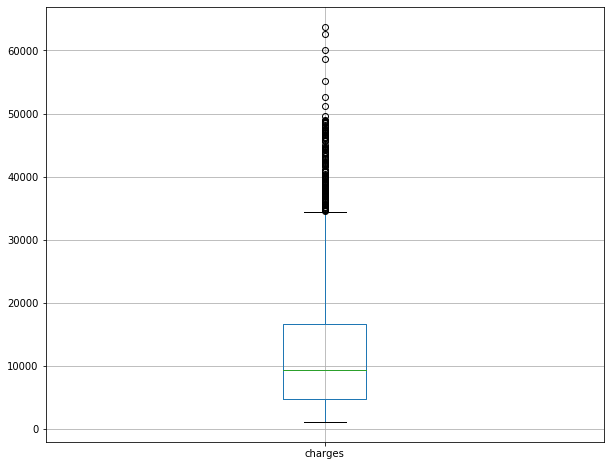

In [75]:
plt.figure(figsize=(10, 8))

data.boxplot('charges')

plt.show()

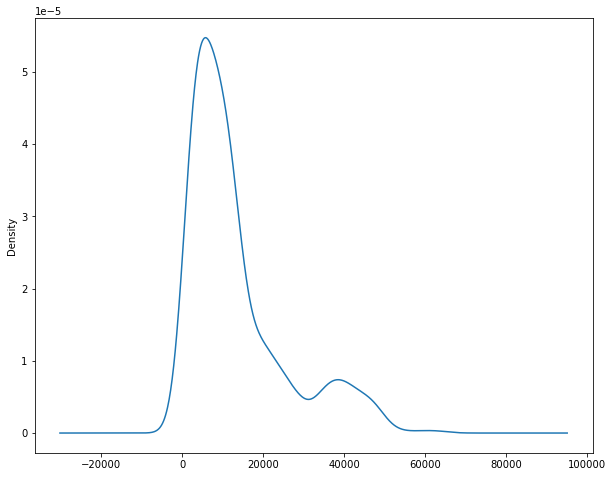

In [9]:
plt.figure(figsize=(10, 8))

data['charges'].plot.kde()

plt.show()

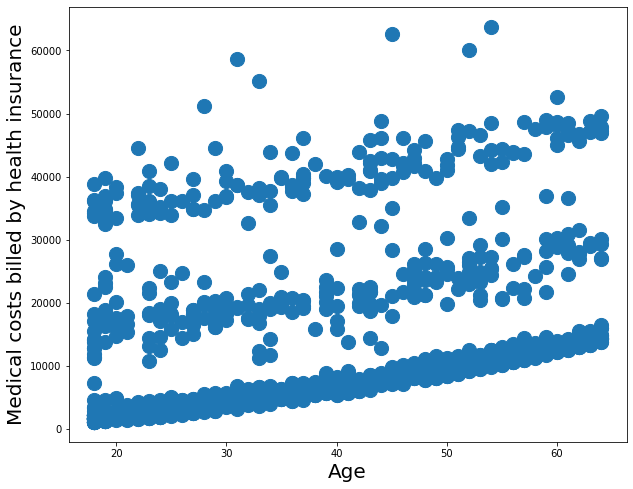

In [77]:
plt.figure(figsize=(10, 8))

plt.scatter(data['age'], data['charges'], s=200)

plt.xlabel('Age', fontsize=20)
plt.ylabel('Medical costs billed by health insurance', fontsize=20)
plt.show()

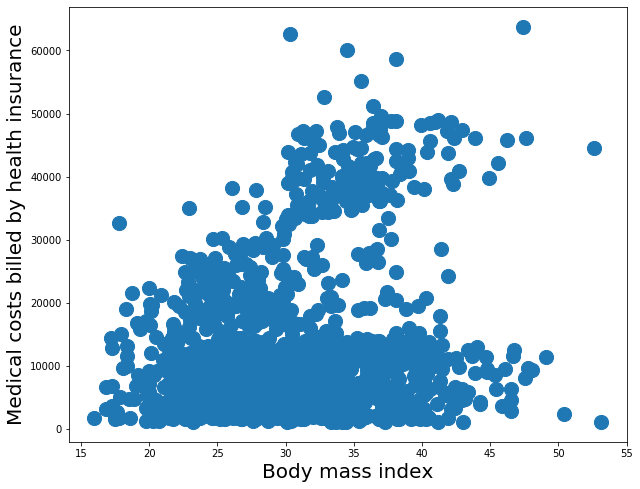

In [78]:
plt.figure(figsize=(10, 8))

plt.scatter(data['bmi'], data['charges'], s=200)

plt.xlabel('Body mass index', fontsize=20)
plt.ylabel('Medical costs billed by health insurance', fontsize=20)
plt.show()

In [19]:
data_corr = data.corr()

data_corr

,age,bmi,children,charges
age,1.000000,0.109272,0.042469,0.299008
bmi,0.109272,1.000000,0.012759,0.198341
children,0.042469,0.012759,1.000000,0.067998
charges,0.299008,0.198341,0.067998,1.000000


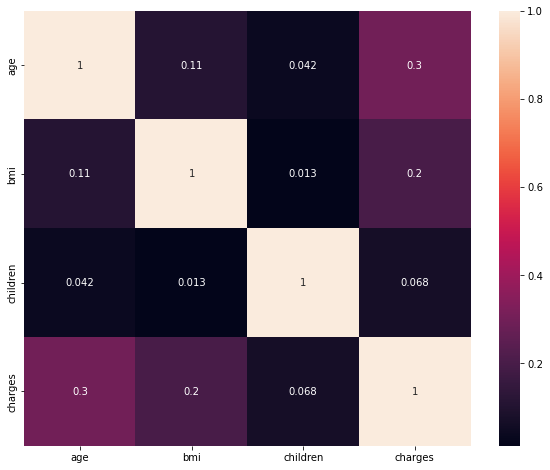

In [20]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(data_corr, annot=True)

plt.show()

# Split data into features and target data frames

In [10]:
features = data.drop('charges', axis=1)

target = data[['charges']]

In [11]:
features.sample(10)

,age,sex,bmi,children,smoker,region
559,19,male,35.530,0,no,northwest
1226,38,male,16.815,2,no,northeast
371,57,female,22.230,0,no,northeast
911,18,male,31.730,0,yes,northeast
1110,54,female,32.300,1,no,northeast
409,32,male,30.030,1,no,southeast
158,30,male,35.530,0,yes,southeast
272,41,male,37.050,2,no,northwest
136,19,male,34.100,0,no,southwest
329,52,male,36.700,0,no,southwest


In [19]:
target.sample(10)

,charges
1299,2710.82855
844,10072.05505
805,7731.85785
776,6986.69700
192,2137.65360
1211,23563.01618
1041,1704.70015
1310,6940.90985
187,5325.65100
52,23568.27200


## Split categorical and numeric features

In [12]:
categorical_features = features[['sex', 'smoker', 'region']].copy()

categorical_features.head()

,sex,smoker,region
0,female,yes,southwest
1,male,no,southeast
2,male,no,southeast
3,male,no,northwest
4,male,no,northwest


In [15]:
numeric_features = features.drop(['sex', 'smoker', 'region'], axis=1)

numeric_features.head()

,age,bmi,children
0,19,27.900,0
1,18,33.770,1
2,28,33.000,3
3,33,22.705,0
4,32,28.880,0


# Feature transformation
## Label encode / one hot encode categorical features

In [16]:
gender_dict = {'female':0, 'male':1}

categorical_features['sex'].replace(gender_dict, inplace=True)

categorical_features.head()

,sex,smoker,region
0,0,yes,southwest
1,1,no,southeast
2,1,no,southeast
3,1,no,northwest
4,1,no,northwest


In [17]:
smoker_dict = {'no':0, 'yes':1}

categorical_features['smoker'].replace(smoker_dict, inplace=True)

categorical_features.head()

,sex,smoker,region
0,0,1,southwest
1,1,0,southeast
2,1,0,southeast
3,1,0,northwest
4,1,0,northwest


In [18]:
categorical_features = pd.get_dummies(categorical_features, columns=['region'])

categorical_features.head()

,sex,smoker,region_northeast,region_northwest,region_southeast,region_southwest
0,0,1,0,0,0,1
1,1,0,0,0,1,0
2,1,0,0,0,1,0
3,1,0,0,1,0,0
4,1,0,0,1,0,0


In [25]:
numeric_features.describe()

,age,bmi,children
count,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918
std,14.049960,6.098187,1.205493
min,18.000000,15.960000,0.000000
25%,27.000000,26.296250,0.000000
50%,39.000000,30.400000,1.000000
75%,51.000000,34.693750,2.000000
max,64.000000,53.130000,5.000000


## Apply standard scaling to numeric features

In [21]:
standardScaler = StandardScaler()

numeric_features = pd.DataFrame(standardScaler.fit_transform(numeric_features), 
                                columns=numeric_features.columns,
                                index=numeric_features.index)

numeric_features.describe()

,age,bmi,children
count,1.338000e+03,1.338000e+03,1.338000e+03
mean,-1.853691e-16,-1.869041e-16,2.721623e-17
std,1.000374e+00,1.000374e+00,1.000374e+00
min,-1.509965e+00,-2.412011e+00,-9.086137e-01
25%,-8.691547e-01,-7.164063e-01,-9.086137e-01
50%,-1.474046e-02,-4.320880e-02,-7.876719e-02
75%,8.396738e-01,6.611572e-01,7.510793e-01
max,1.765289e+00,3.685522e+00,3.240619e+00


In [22]:
processed_features = pd.concat([numeric_features, categorical_features], axis=1,
                               sort=False)

processed_features.head()

,age,bmi,children,sex,smoker,region_northeast,region_northwest,region_southeast,region_southwest
0,-1.438764,-0.453320,-0.908614,0,1,0,0,0,1
1,-1.509965,0.509621,-0.078767,1,0,0,0,1,0
2,-0.797954,0.383307,1.580926,1,0,0,0,1,0
3,-0.441948,-1.305531,-0.908614,1,0,0,1,0,0
4,-0.513149,-0.292556,-0.908614,1,0,0,1,0,0


In [23]:
processed_features.shape

(1338, 9)

In [24]:
target.head(10)

,charges
0,16884.92400
1,1725.55230
2,4449.46200
3,21984.47061
4,3866.85520
5,3756.62160
6,8240.58960
7,7281.50560
8,6406.41070
9,28923.13692


In [25]:
processed_data = pd.concat([processed_features, target], axis=1,
                            sort=False)

processed_data.head()

,age,bmi,children,sex,smoker,region_northeast,region_northwest,region_southeast,region_southwest,charges
0,-1.438764,-0.453320,-0.908614,0,1,0,0,0,1,16884.92400
1,-1.509965,0.509621,-0.078767,1,0,0,0,1,0,1725.55230
2,-0.797954,0.383307,1.580926,1,0,0,0,1,0,4449.46200
3,-0.441948,-1.305531,-0.908614,1,0,0,1,0,0,21984.47061
4,-0.513149,-0.292556,-0.908614,1,0,0,1,0,0,3866.85520


In [26]:
processed_data.to_csv('datasets/insurance_processed.csv', index=False)

### Splitting dataset into training and testing data

In [27]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(processed_features, 
                                                    target, 
                                                    test_size = 0.2, 
                                                    random_state=1)

In [28]:
x_train.shape

(1070, 9)

In [29]:
x_test.shape

(268, 9)

### Building model with relu activation function

In [33]:
def build_model():
    model = tf.keras.Sequential([
        layers.Dense(32, activation='relu', input_shape=[len(x_train.keys())]), # fully connected layer with 32 neurons
        layers.Dense(64, activation='relu'), 
        layers.Dense(1) #output layer - insurance charge
    ])
    
    optimizer = tf.keras.optimizers.Adam(0.001) #updates weights. 0.001 bias

    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mae', 'mse'])
    return model

In [34]:
model_relu_64 = build_model()

model_relu_64.summary() # layers and trainable parameters

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                320       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 2,497
Trainable params: 2,497
Non-trainable params: 0
_________________________________________________________________


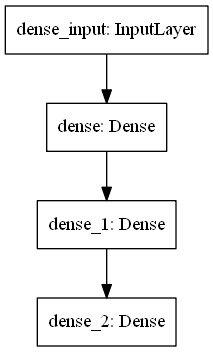

In [35]:
keras.utils.plot_model(model_relu_64, 'model_relu_64.png')

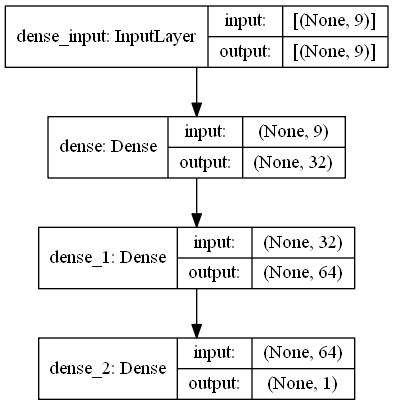

In [36]:
keras.utils.plot_model(model_relu_64, 'model_relu_64_shapes.png', show_shapes=True)

In [38]:
!dir *.png

 Volume in drive C is Windows
 Volume Serial Number is 68A0-930F

 Directory of c:\Users\user\My_Learning\tensorflow\keras\build-machine-learning-workflow-keras-tensorflow

08/09/2021  10:50 AM             6,233 model_relu_64.png
08/09/2021  10:51 AM            17,494 model_relu_64_shapes.png
               2 File(s)         23,727 bytes
               0 Dir(s)  231,234,109,440 bytes free


### Training model

In [39]:
n_epochs = 1000
# fit method splits dataset into batches and trains for the number of epochs specified
training_hist = model_relu_64.fit(x_train, 
                                  y_train,
                                  epochs = n_epochs, 
                                  validation_split = 0.2, 
                                  verbose = True)

Epoch 1/1000
27/27 [==============================] - 4s 18ms/step - loss: 317058496.0000 - mae: 13317.6143 - mse: 317058496.0000 - val_loss: 336105600.0000 - val_mae: 12876.8447 - val_mse: 336105600.0000
Epoch 2/1000
27/27 [==============================] - 0s 5ms/step - loss: 317011360.0000 - mae: 13315.8740 - mse: 317011360.0000 - val_loss: 336040320.0000 - val_mae: 12874.3906 - val_mse: 336040320.0000
Epoch 3/1000
27/27 [==============================] - 0s 5ms/step - loss: 316910176.0000 - mae: 13312.2598 - mse: 316910176.0000 - val_loss: 335893184.0000 - val_mae: 12869.0469 - val_mse: 335893184.0000
Epoch 4/1000
27/27 [==============================] - 0s 4ms/step - loss: 316698944.0000 - mae: 13304.7861 - mse: 316698944.0000 - val_loss: 335590304.0000 - val_mae: 12858.4805 - val_mse: 335590304.0000
Epoch 5/1000
27/27 [==============================] - 0s 4ms/step - loss: 316296672.0000 - mae: 13291.3643 - mse: 316296672.0000 - val_loss: 335053184.0000 - val_mae: 12840.1533 - val

In [40]:
# Inspect history of model training by epoch
training_hist_df = pd.DataFrame(training_hist.history)

training_hist_df['epoch'] = training_hist.epoch

training_hist_df.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,20657132.0,2706.025879,20657132.0,21591030.0,2655.948242,21591030.0,995
996,20656190.0,2695.809814,20656190.0,21566432.0,2648.209717,21566432.0,996
997,20666560.0,2658.669678,20666560.0,21474772.0,2609.550537,21474772.0,997
998,20653750.0,2696.726318,20653750.0,21627868.0,2674.963867,21627868.0,998
999,20672178.0,2691.293457,20672178.0,21512896.0,2629.404297,21512896.0,999


In [41]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

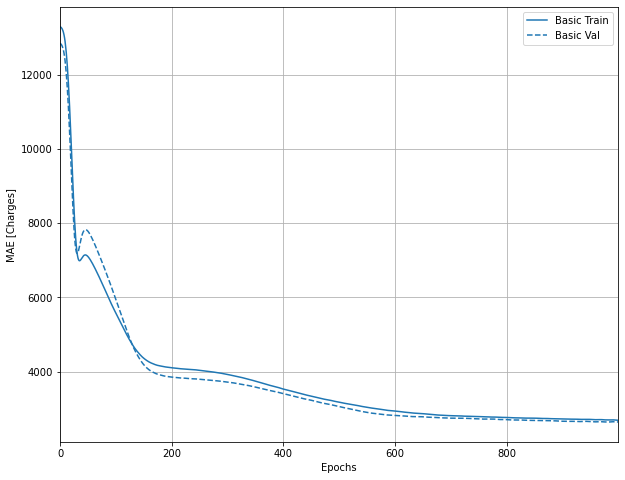

In [42]:
plt.figure(figsize=(10, 8))

plotter.plot({'Basic': training_hist}, metric = "mae")

plt.ylabel('MAE [Charges]')
plt.show()

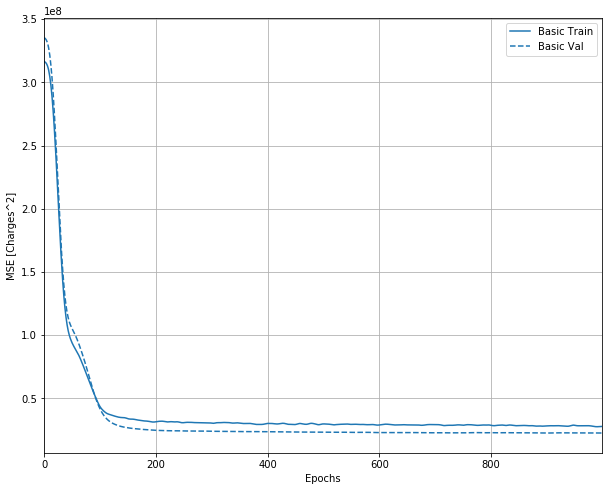

In [82]:
plt.figure(figsize=(10, 8))

plotter.plot({'Basic': training_hist}, metric = "mse")

plt.ylabel('MSE [Charges^2]')
plt.show()

### Plotting scatter plot for actual and predicted charges

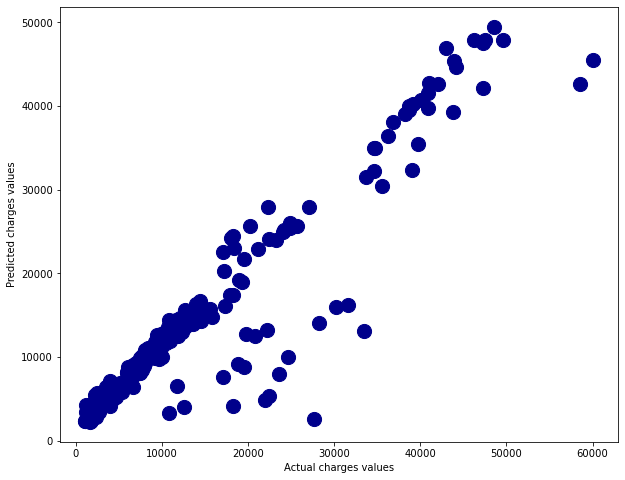

In [43]:
y_pred = model_relu_64.predict(x_test).flatten()

plt.figure(figsize=(10, 8))

plt.scatter(y_test, y_pred, s=200, c='darkblue')

plt.xlabel('Actual charges values')
plt.ylabel('Predicted charges values')
plt.show()

In [88]:
# Evaluate perf with R^2, measure of how much of the underlying variance captured by model
r2_score(y_test, y_pred)

0.854837846078773

### Building model with relu activation function

In [44]:
def build_model():
    model = tf.keras.Sequential([
        layers.Dense(32, activation='elu', input_shape=[len(x_train.keys())]),
        layers.Dropout(0.2), # regulrarisation
        layers.Dense(64, activation='elu'),
        layers.Dense(1)
    ])
    
    optimizer = tf.keras.optimizers.Adam(0.001)

    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mae', 'mse'])
    return model

In [45]:
model_elu_64 = build_model()

model_elu_64.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 32)                320       
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 2,497
Trainable params: 2,497
Non-trainable params: 0
_________________________________________________________________


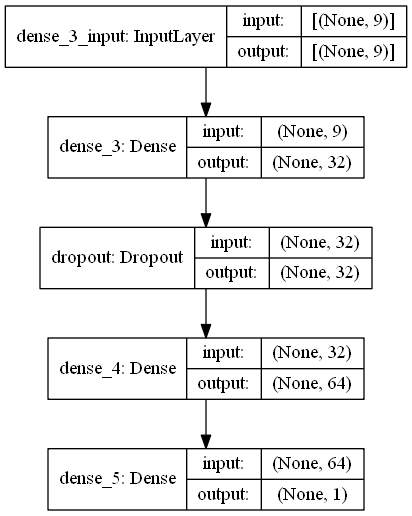

In [46]:
keras.utils.plot_model(model_elu_64, 'model_elu_64_shapes.png', show_shapes=True)

### Training model (build with elu activation function and dropout)

In [47]:
training_hist= model_elu_64.fit(x_train, 
                                y_train,
                                epochs = n_epochs, 
                                validation_split = 0.2, 
                                verbose = False,
                                callbacks=[tfdocs.modeling.EpochDots()] # visualise each training batch with epoch dots
                                ) 


Epoch: 0, loss:317043552.0000,  mae:13317.1709,  mse:317043552.0000,  val_loss:336075232.0000,  val_mae:12876.0586,  val_mse:336075232.0000,  
....................................................................................................
Epoch: 100, loss:42409108.0000,  mae:4710.2529,  mse:42409108.0000,  val_loss:39713784.0000,  val_mae:4641.1079,  val_mse:39713784.0000,  
....................................................................................................
Epoch: 200, loss:32019684.0000,  mae:3819.9629,  mse:32019684.0000,  val_loss:24888754.0000,  val_mae:3095.2603,  val_mse:24888754.0000,  
....................................................................................................
Epoch: 300, loss:32292990.0000,  mae:3785.7424,  mse:32292990.0000,  val_loss:24031728.0000,  val_mae:3001.5984,  val_mse:24031728.0000,  
....................................................................................................
Epoch: 400, loss:28722398.0000,  ma

In [48]:
training_hist_df = pd.DataFrame(training_hist.history)

training_hist_df['epoch'] = training_hist.epoch

training_hist_df.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,27374036.0,3391.362061,27374036.0,22454898.0,2731.363037,22454898.0,995
996,27632838.0,3383.015381,27632838.0,22454224.0,2680.246826,22454224.0,996
997,28517148.0,3492.457031,28517148.0,22468168.0,2721.772217,22468168.0,997
998,27813254.0,3449.458496,27813254.0,22492624.0,2733.526855,22492624.0,998
999,28266378.0,3399.167725,28266378.0,22497496.0,2753.894531,22497496.0,999


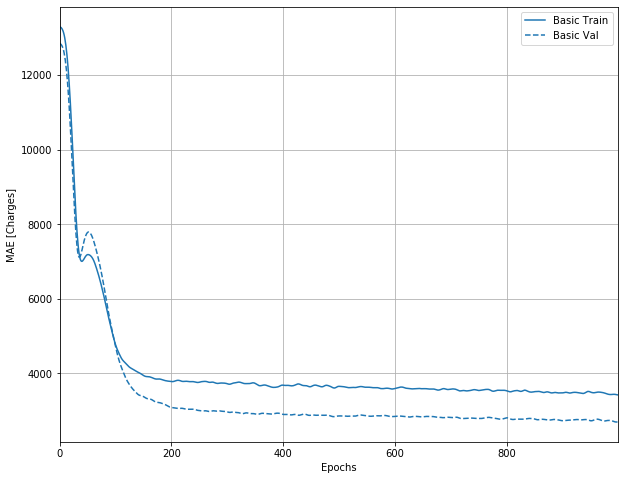

In [84]:
plt.figure(figsize=(10, 8))

plotter.plot({'Basic': training_hist}, metric = "mae")

plt.ylabel('MAE [Charges]')
plt.show()
# loss is lower on validation set, due to application of dropout layer

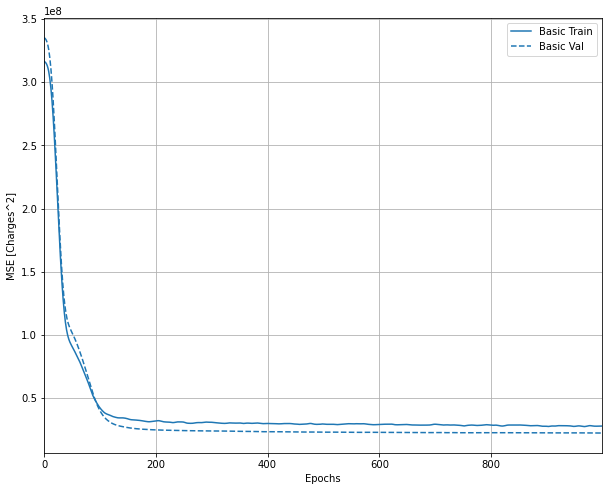

In [49]:
plt.figure(figsize=(10, 8))

plotter.plot({'Basic': training_hist}, metric = "mse")

plt.ylabel('MSE [Charges^2]')
plt.show()

In [50]:
# Evaluate model performance on test data
model_elu_64.evaluate(x_test, y_test)

9/9 [==============================] - 0s 2ms/step - loss: 21547662.0000 - mae: 2851.3379 - mse: 21547662.0000


[21547662.0, 2851.337890625, 21547662.0]

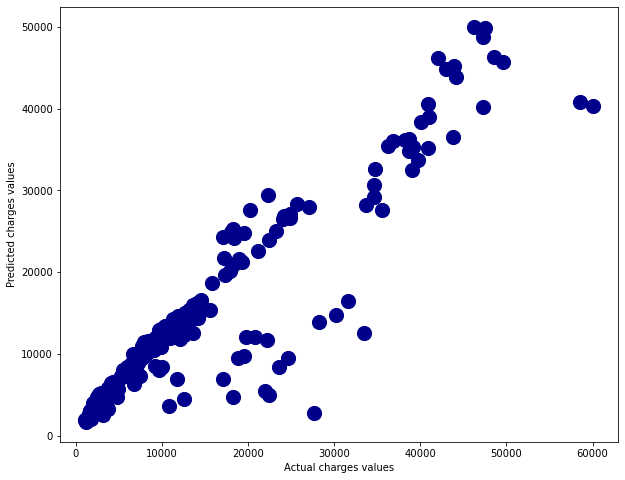

In [51]:
y_pred = model_elu_64.predict(x_test).flatten()

plt.figure(figsize=(10, 8))

plt.scatter(y_test, y_pred, s=200, c='darkblue')

plt.xlabel('Actual charges values')
plt.ylabel('Predicted charges values')
plt.show()

In [52]:
r2_score(y_test, y_pred)

0.8556566864920481

### Building model with Earlystopping callback

In [53]:
model_relu_with_ES = build_model()

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5) # if validation loss does not reduce after 5 epochs, stop training

training_history = model_relu_with_ES.fit(x_train, 
                                       y_train, 
                                       epochs=n_epochs, 
                                       validation_split = 0.2, 
                                       verbose=False, 
                                       callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:317064064.0000,  mae:13317.8867,  mse:317064064.0000,  val_loss:336095680.0000,  val_mae:12876.9395,  val_mse:336095680.0000,  
....................................................................................................
Epoch: 100, loss:42520280.0000,  mae:4594.5688,  mse:42520280.0000,  val_loss:37015768.0000,  val_mae:4341.5435,  val_mse:37015768.0000,  
....................................................................................................
Epoch: 200, loss:33209830.0000,  mae:3878.2664,  mse:33209830.0000,  val_loss:24340696.0000,  val_mae:3057.5371,  val_mse:24340696.0000,  
........................................

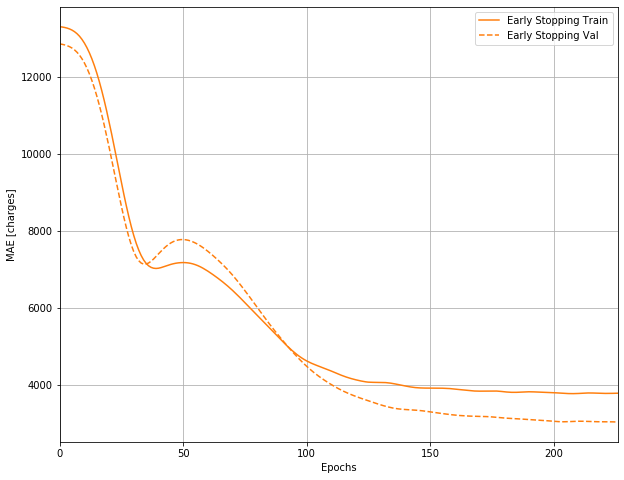

In [90]:
plt.figure(figsize=(10, 8))

plotter.plot({'Early Stopping': training_history}, metric = "mae")

plt.ylabel('MAE [charges]')
plt.show()

In [54]:
model_relu_with_ES.evaluate(x_test, y_test)

9/9 [==============================] - 0s 1ms/step - loss: 23799872.0000 - mae: 3040.5498 - mse: 23799872.0000


[23799872.0, 3040.5498046875, 23799872.0]

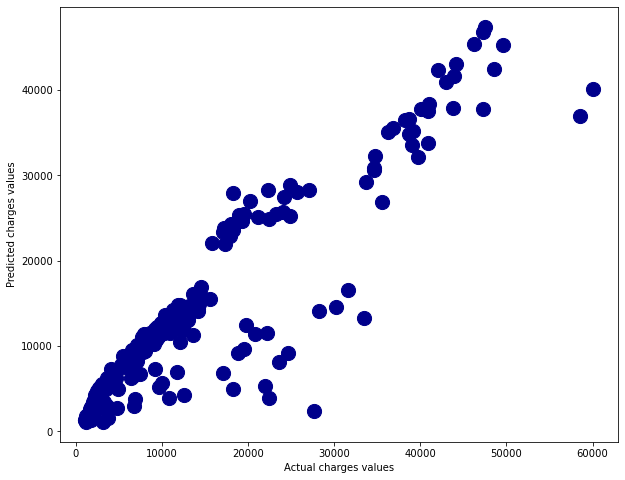

In [55]:
y_pred = model_relu_with_ES.predict(x_test).flatten()

plt.figure(figsize=(10, 8))

plt.scatter(y_test, y_pred, s=200, c='darkblue')

plt.xlabel('Actual charges values')
plt.ylabel('Predicted charges values')
plt.show()

In [56]:
r2_score(y_test, y_pred)

0.840569606468579

In [57]:
model_relu_with_ES.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 32)                320       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 2,497
Trainable params: 2,497
Non-trainable params: 0
_________________________________________________________________


In [69]:
# saves all model trainable parameters - can re-use weights to continue training or predict
model_relu_with_ES.save_weights("./my_models/relu_64_weights")

saves checkpoints whic include 1 or more shards which include trained weights and an index file that indicates which weights are present in which shard

In [77]:
!dir my_models

 Volume in drive C is Windows
 Volume Serial Number is 68A0-930F

 Directory of c:\Users\user\My_Learning\tensorflow\keras\build-machine-learning-workflow-keras-tensorflow\my_models

08/09/2021  11:15 AM    <DIR>          .
08/09/2021  11:15 AM    <DIR>          ..
08/09/2021  11:15 AM                87 checkpoint
08/09/2021  11:15 AM            32,829 relu_64_weights.data-00000-of-00001
08/09/2021  11:15 AM             1,603 relu_64_weights.index
               3 File(s)         34,519 bytes
               2 Dir(s)  231,240,208,384 bytes free


Model weights can also be stored in the Hierachical Data Format (HDF) which is designed to store ane organise large amounts of data - lightweight alternative to saved model format. Most appropriate for multi-backend implementation of Keras

In [78]:
model_relu_with_ES.save_weights("./my_models/relu_64_weights.h5", save_format="h5")

ImportError: `save_weights` requires h5py when saving in hdf5.

In [79]:
!dir my_models

 Volume in drive C is Windows
 Volume Serial Number is 68A0-930F

 Directory of c:\Users\user\My_Learning\tensorflow\keras\build-machine-learning-workflow-keras-tensorflow\my_models

08/09/2021  11:15 AM    <DIR>          .
08/09/2021  11:15 AM    <DIR>          ..
08/09/2021  11:15 AM                87 checkpoint
08/09/2021  11:15 AM            32,829 relu_64_weights.data-00000-of-00001
08/09/2021  11:15 AM             1,603 relu_64_weights.index
               3 File(s)         34,519 bytes
               2 Dir(s)  231,237,349,376 bytes free


In [80]:
# Save architectural config of model, which allows us to reconstruct the model
relu_64_json = model_relu_with_ES.to_json()

pprint.pprint(json.loads(relu_64_json))

{'backend': 'tensorflow',
 'class_name': 'Sequential',
 'config': {'layers': [{'class_name': 'InputLayer',
                        'config': {'batch_input_shape': [None, 9],
                                   'dtype': 'float32',
                                   'name': 'dense_6_input',
                                   'ragged': False,
                                   'sparse': False}},
                       {'class_name': 'Dense',
                        'config': {'activation': 'elu',
                                   'activity_regularizer': None,
                                   'batch_input_shape': [None, 9],
                                   'bias_constraint': None,
                                   'bias_initializer': {'class_name': 'Zeros',
                                                        'config': {}},
                                   'bias_regularizer': None,
                                   'dtype': 'float32',
                                   'kernel_c

In [81]:
with open('./my_models/relu_64_config.json', 'w') as outfile: 
    
    outfile.write(relu_64_json) 

In [82]:
!cat my_models/relu_64_config.json

'cat' is not recognized as an internal or external command,
operable program or batch file.


### Saving entire model
This is the best way to save all parts of model in TensofrFlow `SavedModel` format. Model architecture and training config are in `saved_model.pb`. Model weights are stored in the `variables/` directory. Any other artifacts are stored in the `assets` directory

In [83]:
model_relu_with_ES.save("./my_models/relu_64_config_weights")

INFO:tensorflow:Assets written to: ./my_models/relu_64_config_weights\assets


In [94]:
!dir my_models\relu_64_config_weights

 Volume in drive C is Windows
 Volume Serial Number is 68A0-930F

 Directory of c:\Users\user\My_Learning\tensorflow\keras\build-machine-learning-workflow-keras-tensorflow\my_models\relu_64_config_weights

08/09/2021  11:25 AM    <DIR>          .
08/09/2021  11:25 AM    <DIR>          ..
08/09/2021  11:25 AM    <DIR>          assets
08/09/2021  11:25 AM             9,344 keras_metadata.pb
08/09/2021  11:25 AM           101,795 saved_model.pb
08/09/2021  11:25 AM    <DIR>          variables
               2 File(s)        111,139 bytes
               4 Dir(s)  231,235,186,688 bytes free
